In [54]:
# pip install numpy pandas torch scikit-learn
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F


### Model Structure

In [2]:
# Fourier Transform for the linear transformer encoder
class FourierTransform(nn.Module):
    def __init__(self):
        super(FourierTransform, self).__init__()

    def forward(self, x):
        # Apply the 2D Fourier transform to the last two dimensions
        return torch.fft.fft2(x).real

# Define the Multiplexed Attention mechanism

# Define the Positionwise Feed-Forward Network
class PositionwiseFeedforward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedforward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(F.relu(self.linear1(x))))

#Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.fourier_transform = FourierTransform()
        self.feed_forward = PositionwiseFeedforward(d_model, d_ff, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask=None):
        # Applying Fourier Transform as a replacement for MHA
        src2 = self.fourier_transform(src)
        src = self.layernorm1(src + self.dropout(src2))

        # Positionwise Feedforward Network
        src2 = self.feed_forward(src)
        src = self.layernorm2(src + self.dropout(src2))

        return src

#Decoder Layer
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.feed_forward = PositionwiseFeedforward(d_model, d_ff, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask, memory_mask):
        # Self-attention on the targets
        tgt2 = self.layernorm1(tgt)
        tgt2 = self.self_attn(tgt2, tgt2, tgt2, attn_mask=tgt_mask)[0]
        tgt = tgt + self.dropout(tgt2)

        # Attention over encoder's output
        tgt2 = self.layernorm2(tgt)
        tgt2 = self.multihead_attn(tgt2, memory, memory, attn_mask=memory_mask)[0]
        tgt = tgt + self.dropout(tgt2)

        # Positionwise feedforward
        tgt2 = self.layernorm3(tgt)
        tgt = tgt + self.dropout(self.feed_forward(tgt2))
        
        return tgt
    
class LinearTransformer(nn.Module):
    def __init__(self, feature_size, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super(LinearTransformer, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.fourier_transform = FourierTransform()  # Fourier transform layer
        self.positional_encoder = nn.Embedding(1000, d_model)  # Customize based on max sequence length
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(d_model, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([TransformerDecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.output_layer = nn.Linear(d_model, feature_size)  # Adjust depending on your output size

    def forward(self, src, src_mask=None, tgt=None, tgt_mask=None):
        batch_size, seq_length, _ = src.size()

        # Positional Encoding
        positions = torch.arange(seq_length, device=src.device).unsqueeze(0).repeat(batch_size, 1)
        src = src + self.positional_encoder(positions)

        # Fourier Transform
        src = self.fourier_transform(src)

        # Encoder
        for layer in self.encoder_layers:
            src = layer(src, src_mask=src_mask)

        if tgt is not None:
            # If there is a target sequence (for tasks that use the decoder)
            tgt = tgt + self.positional_encoder(positions[:tgt.size(1), :])
            for layer in self.decoder_layers:
                tgt = layer(tgt, src, tgt_mask=tgt_mask)

            # Output layer for decoder output
            return self.output_layer(tgt)

        # Output layer to convert encoder output back to feature size (if only using the encoder)
        return self.output_layer(src)
    

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq




### Data Preparation

In [40]:
# Load your dataset
df = pd.read_csv('/Users/oli/Documents/GitHub/Linear_Trans/stock_data/TSLA.csv') 

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)  # Remove NaNs
scaler = MinMaxScaler(feature_range=(-1, 1))
df['log_return'] = scaler.fit_transform(df['log_return'].values.reshape(-1,1))
# Convert the DataFrame to a PyTorch Tensor
data = torch.FloatTensor(df['log_return'].values).view(-1)


# Define your sequence length
seq_length = 20  # Based on how many days you want to use to predict the next day
# Create sequences
inout_seq = create_inout_sequences(data, seq_length)


# Split your data into train and test sets
train_size = int(len(inout_seq) * 0.80)
train_set = inout_seq[:train_size]
test_set = inout_seq[train_size:]
# Prepare DataLoader
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

### Training and Test Process

In [41]:
# Instantiate the model, loss function, and optimizer
model = LinearTransformer(feature_size=1, num_layers=2, d_model=64, d_ff = 2048, num_heads=8)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [42]:
train_losses = []
test_losses = []
num_epochs = 50 

for epoch in range(num_epochs):
    epoch_train_loss = []
    for seq, labels in train_loader:
        optimizer.zero_grad()
        y_pred = model(seq.unsqueeze(-1))  # Adjust dimensions if necessary
        labels = labels.view(-1)  # Ensure label dimensions match output
        loss = criterion(y_pred[:, -1], labels)  # Assuming using last output for prediction
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    
    # Calculate and store the average training loss for this epoch
    train_losses.append(np.mean(epoch_train_loss))

    # Validation or Testing phase
    epoch_test_loss = []
    with torch.no_grad():
        for seq, labels in test_loader:
            y_pred = model(seq.unsqueeze(-1))
            labels = labels.view(-1)
            loss = criterion(y_pred[:, -1], labels)
            epoch_test_loss.append(loss.item())
    
    # Calculate and store the average test loss for this epoch
    test_losses.append(np.mean(epoch_test_loss))
    
    # Optional: print out loss information to monitor progress
    print(f'Epoch {epoch+1}/{num_epochs} - Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')


# Assuming 'model' is your model instance and it has been trained
torch.save(model.state_dict(), 'transformer_fourier.pth')



/Users/oli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/oli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([55])) that is different to the input size (torch.Size([55, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/oli/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46])) that is different to the input size (torch.Size([46, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same si

Epoch 1/50 - Training Loss: 3.2409, Test Loss: 0.1410
Epoch 2/50 - Training Loss: 0.7072, Test Loss: 0.8282
Epoch 3/50 - Training Loss: 0.4160, Test Loss: 0.0924
Epoch 4/50 - Training Loss: 0.1827, Test Loss: 0.3107
Epoch 5/50 - Training Loss: 0.2892, Test Loss: 0.1532
Epoch 6/50 - Training Loss: 0.1192, Test Loss: 0.0961
Epoch 7/50 - Training Loss: 0.0802, Test Loss: 0.1402
Epoch 8/50 - Training Loss: 0.1116, Test Loss: 0.1502
Epoch 9/50 - Training Loss: 0.1069, Test Loss: 0.1238
Epoch 10/50 - Training Loss: 0.0830, Test Loss: 0.0915
Epoch 11/50 - Training Loss: 0.0727, Test Loss: 0.0902
Epoch 12/50 - Training Loss: 0.0793, Test Loss: 0.0944
Epoch 13/50 - Training Loss: 0.0825, Test Loss: 0.0896
Epoch 14/50 - Training Loss: 0.0756, Test Loss: 0.0918
Epoch 15/50 - Training Loss: 0.0707, Test Loss: 0.0962
Epoch 16/50 - Training Loss: 0.0731, Test Loss: 0.1023
Epoch 17/50 - Training Loss: 0.0741, Test Loss: 0.1012
Epoch 18/50 - Training Loss: 0.0725, Test Loss: 0.0903
Epoch 19/50 - Train

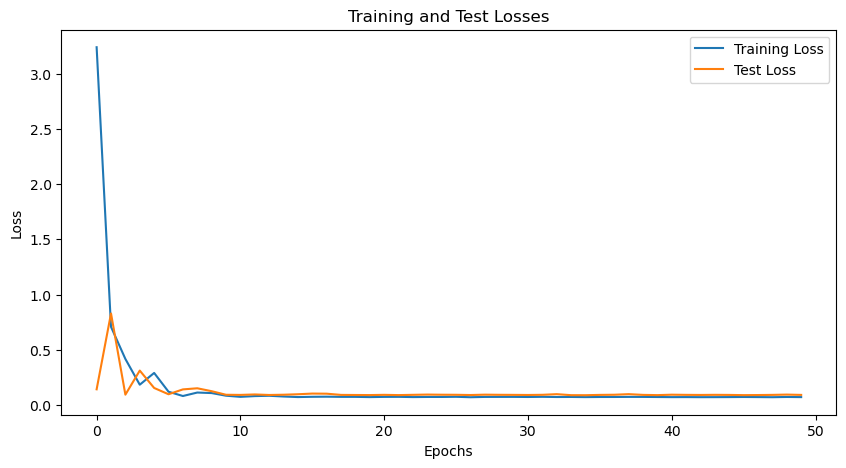

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Prediction

Load the saved model.

In [44]:
# Instantiate the model
model = LinearTransformer(feature_size=1, num_layers=2, d_model=64, num_heads=8, d_ff=2048, dropout=0.1)

# Load the weights
model.load_state_dict(torch.load('transformer_fourier.pth'))
model.eval()  # Set the model to evaluation mode


LinearTransformer(
  (fourier_transform): FourierTransform()
  (positional_encoder): Embedding(1000, 64)
  (encoder_layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (fourier_transform): FourierTransform()
      (feed_forward): PositionwiseFeedforward(
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
      )
      (layernorm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layernorm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-1): 2 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64,

Using the stock data of Apple.

In [34]:
# Assuming you have new input data for prediction
df = pd.read_csv('/Users/oli/Documents/GitHub/Linear_Trans/stock_data/AAPL.csv') 

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)  # Remove NaNs
scaler = MinMaxScaler(feature_range=(-1, 1))
df['log_return'] = scaler.fit_transform(df['log_return'].values.reshape(-1,1))
new_input_data = df['log_return']  # This should be your new input data

# Scale and preprocess your new data
new_input_scaled = scaler.transform(np.array(new_input_data).reshape(-1, 1))

# Convert to Tensor
new_input_tensor = torch.FloatTensor(new_input_scaled).view(-1)

# Create sequences (same sequence length as used during training)
new_sequences = create_inout_sequences(new_input_tensor, seq_length)

# Extract just the sequence part (ignoring labels if it's purely for prediction)
new_sequences = [seq[0] for seq in new_sequences]  # Assuming you only need the sequences

# Optionally, convert to a DataLoader if dealing with many sequences
predict_loader = DataLoader(new_sequences, batch_size=64, shuffle=False)


In [ ]:
predictions = []
with torch.no_grad():
    for sequences in predict_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # If you're predicting the last value
        predictions.extend(predicted_values.numpy())

# Inverse transform the predictions if necessary
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


# Further processing based on your application's needs



In [37]:
last_known_price = df['Close'].iloc[-1]
predicted_prices = [last_known_price]


predicted_price = predicted_prices[-1] * np.exp(predictions[0])
predicted_prices.append(predicted_price)

# The predicted price for the next time step after the last sequence in your test data
next_predicted_price = predicted_prices[-1]
print(f"Predicted price for the next time step: {next_predicted_price}")

Predicted price for the next time step: [169.12413]


### Test of NVDA

Test on NVDA.csv

In [73]:
# Assuming you have new input data for prediction
df = pd.read_csv('/Users/oli/Documents/GitHub/Linear_Trans/stock_data/NVDA.csv') 

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)  # Remove NaNs
scaler = MinMaxScaler(feature_range=(-1, 1))
df['log_return'] = scaler.fit_transform(df['log_return'].values.reshape(-1,1))
new_input_data = df['log_return']  # This should be your new input data

# Scale and preprocess your new data
new_input_scaled = scaler.transform(np.array(new_input_data).reshape(-1, 1))

# Convert to Tensor
new_input_tensor = torch.FloatTensor(new_input_scaled).view(-1)

# Create sequences (same sequence length as used during training)
new_sequences = create_inout_sequences(new_input_tensor, seq_length)

# Extract just the sequence part (ignoring labels if it's purely for prediction)
new_sequences = [seq[0] for seq in new_sequences]  # Assuming you only need the sequences

# Optionally, convert to a DataLoader if dealing with many sequences
predict_loader = DataLoader(new_sequences, batch_size=64, shuffle=False)

predictions = []
with torch.no_grad():
    for sequences in predict_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # If you're predicting the last value
        predictions.extend(predicted_values.numpy())

# Inverse transform the predictions if necessary

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
last_known_price = df['Close'].iloc[-1]
predicted_prices = [last_known_price]


predicted_price = predicted_prices[-1] * np.exp(predictions[0])
predicted_prices.append(predicted_price)

# The predicted price for the next time step after the last sequence in your test data
next_predicted_price = predicted_prices[-1]
print(f"Predicted price for the next time step: {next_predicted_price}")

Predicted price for the next time step: [1001.60956]


Using the mean_absolute_error to calculate the MAE.

In [56]:
from sklearn.metrics import mean_absolute_error


In [58]:
# Assuming `test_loader` provides both sequences and actual labels (prices or returns)
predictions = []
actuals = []
model.eval()
with torch.no_grad():
    for sequences, actual in test_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # Assuming using last output for prediction
        predictions.extend(predicted_values.cpu().numpy())
        actuals.extend(actual.cpu().numpy())

# Convert predictions and actuals to the original scale if they were normalized or scaled
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Compute MAE
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 0.02113822102546692


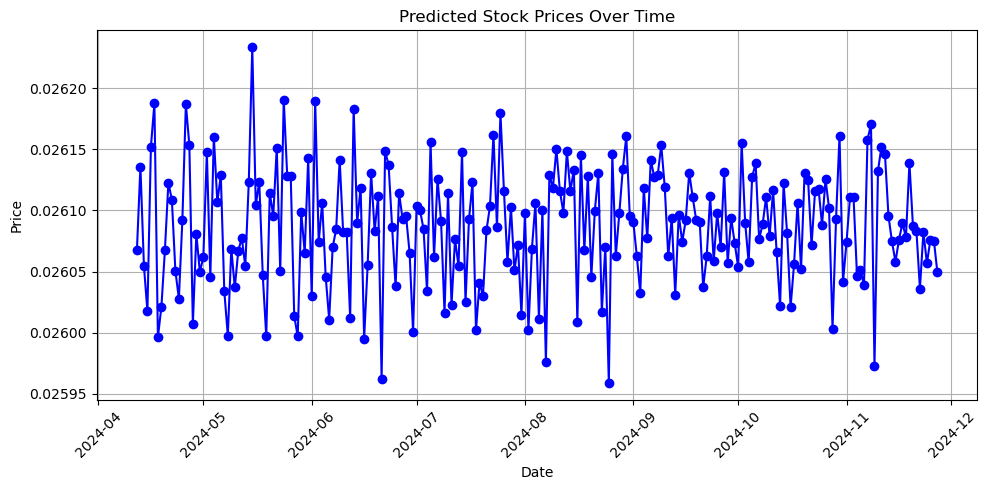

In [51]:
date_range = pd.date_range(start=df['Date'].iloc[-1], periods=len(predictions)+1, freq='D')
date_range = date_range[1:]

plot_data = pd.DataFrame({
    'Date': date_range,
    'Predicted_Price': predictions.flatten()  # Flatten the predictions array if necessary
})

plt.figure(figsize=(10, 5))
plt.plot(plot_data['Date'], plot_data['Predicted_Price'], marker='o', linestyle='-', color='blue')
plt.title('Predicted Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better readability
plt.tight_layout()  # Adjust layout to make room for date labels

# Show the plot
plt.show()

### Test on JPM

In [71]:
# Assuming you have new input data for prediction
df = pd.read_csv('/Users/oli/Documents/GitHub/Linear_Trans/stock_data/JPM.csv') 

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)  # Remove NaNs
scaler = MinMaxScaler(feature_range=(-1, 1))
df['log_return'] = scaler.fit_transform(df['log_return'].values.reshape(-1,1))
new_input_data = df['log_return']  # This should be your new input data

# Scale and preprocess your new data
new_input_scaled = scaler.transform(np.array(new_input_data).reshape(-1, 1))

# Convert to Tensor
new_input_tensor = torch.FloatTensor(new_input_scaled).view(-1)

# Create sequences (same sequence length as used during training)
new_sequences = create_inout_sequences(new_input_tensor, seq_length)

# Extract just the sequence part (ignoring labels if it's purely for prediction)
new_sequences = [seq[0] for seq in new_sequences]  # Assuming you only need the sequences

# Optionally, convert to a DataLoader if dealing with many sequences
predict_loader = DataLoader(new_sequences, batch_size=64, shuffle=False)

predictions = []
with torch.no_grad():
    for sequences in predict_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # If you're predicting the last value
        predictions.extend(predicted_values.numpy())

# Inverse transform the predictions if necessary
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


last_known_price = df['Close'].iloc[-1]
predicted_prices = [last_known_price]


predicted_price = predicted_prices[-1] * np.exp(predictions[0])
predicted_prices.append(predicted_price)

# The predicted price for the next time step after the last sequence in your test data
next_predicted_price = predicted_prices[-1]
print(f"Predicted price for the next time step: {next_predicted_price}")

Predicted price for the next time step: [200.59137]


In [67]:
# Assuming `test_loader` provides both sequences and actual labels (prices or returns)
predictions = []
actuals = []
model.eval()
with torch.no_grad():
    for sequences, actual in test_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # Assuming using last output for prediction
        predictions.extend(predicted_values.cpu().numpy())
        actuals.extend(actual.cpu().numpy())

# Convert predictions and actuals to the original scale if they were normalized or scaled
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Compute MAE
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.01132914423942566


### Test on SP500 index

In [70]:
# Assuming you have new input data for prediction
df = pd.read_csv('/Users/oli/Documents/GitHub/Linear_Trans/stock_data/SP500_index.csv') 

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)  # Remove NaNs
scaler = MinMaxScaler(feature_range=(-1, 1))
df['log_return'] = scaler.fit_transform(df['log_return'].values.reshape(-1,1))
new_input_data = df['log_return']  # This should be your new input data

# Scale and preprocess your new data
new_input_scaled = scaler.transform(np.array(new_input_data).reshape(-1, 1))

# Convert to Tensor
new_input_tensor = torch.FloatTensor(new_input_scaled).view(-1)

# Create sequences (same sequence length as used during training)
new_sequences = create_inout_sequences(new_input_tensor, seq_length)

# Extract just the sequence part (ignoring labels if it's purely for prediction)
new_sequences = [seq[0] for seq in new_sequences]  # Assuming you only need the sequences

# Optionally, convert to a DataLoader if dealing with many sequences
predict_loader = DataLoader(new_sequences, batch_size=64, shuffle=False)

predictions = []
with torch.no_grad():
    for sequences in predict_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # If you're predicting the last value
        predictions.extend(predicted_values.numpy())

# Inverse transform the predictions if necessary

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
last_known_price = df['Close'].iloc[-1]
predicted_prices = [last_known_price]


predicted_price = predicted_prices[-1] * np.exp(predictions[0])
predicted_prices.append(predicted_price)

# The predicted price for the next time step after the last sequence in your test data
next_predicted_price = predicted_prices[-1]
print(f"Predicted price for the next time step: {next_predicted_price}")

Predicted price for the next time step: [2734.6062]


In [69]:
# Assuming `test_loader` provides both sequences and actual labels (prices or returns)
predictions = []
actuals = []
model.eval()
with torch.no_grad():
    for sequences, actual in test_loader:
        sequences = sequences.view(sequences.shape[0], seq_length, 1)  # Reshape if necessary
        output = model(sequences)
        predicted_values = output[:, -1]  # Assuming using last output for prediction
        predictions.extend(predicted_values.cpu().numpy())
        actuals.extend(actual.cpu().numpy())

# Convert predictions and actuals to the original scale if they were normalized or scaled
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1))

# Compute MAE
mae = mean_absolute_error(actuals, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 0.02113822102546692
